In [1]:
# 10 class
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision
import numpy as np
from torch.utils.data import Subset
from moe import *
device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [2]:
import argparse
import argparse
import sys

# 检查并移除 Jupyter 传递的参数
if any('--f=' in arg for arg in sys.argv):
    # 移除包含 '--f=' 的所有参数
    sys.argv = [arg for arg in sys.argv if not arg.startswith('--f=')]
def parse_args():
    parser = argparse.ArgumentParser(description="Train a Mixture-of-Experts model.")
    parser.add_argument("--epochs", type=int, default=50, help="Number of epochs to train.")
    parser.add_argument("--batch_size", type=int, default=50, help="Batch size for training.")
    parser.add_argument("--input_size", type=int, default=64, help="Input size for the moe.")
    parser.add_argument("--num_experts", type=int, default=10, help="Number of experts.")
    parser.add_argument("--hidden_size", type=int, default=64, help="Hidden size for the moe.")
    parser.add_argument("--depth", type=int, default=1, help="Depth of the experts.")
    parser.add_argument("--output_size", type=int, default=10, help="Output size for the experts.")
    parser.add_argument("--activation", type=str, default="tanh", help="Activation function for the moe.")
    parser.add_argument("--k", type=int, default=1, help="Top-k experts to use.")
    parser.add_argument("--loss_coef", type=float, default=1, help="Coefficient for the loss.")
    parser.add_argument("--smooth_steps",type=int,default=2,help="number of steps for smooth mode")
    parser.add_argument("--smooth_lb",type=int,default=100,help="number lower bound of steps for smooth mode")
    parser.add_argument("--seed",type=int,default=1234) #1234
    return parser.parse_args()
args=parse_args()
torch.manual_seed(args.seed)

In [3]:
# MoE= ResNet_MOE_Model(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef).to(device)
# MoE= ResNet_multiMOE_Model(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef).to(device)
MoE= ResNet20().to(device)

In [4]:
criterion = nn.CrossEntropyLoss()

# 优化器不变
optimizer = torch.optim.SGD(MoE.parameters(), lr=8e-3, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
step_count=args.smooth_steps

for epoch in range(args.epochs):  # loop over the dataset multiple times
    MoE.train()
    running_loss = 0.0
    running_aux_loss = 0.0
    
    # step_count -=1
    # if MoE.moe[1].smooth and step_count<=0:
    #     MoE.moe[1].smoothing(epoch,args.smooth_lb)
    #     step_count=args.smooth_steps
    # elif step_count<=0 :
    #     MoE.moe[1].smoothing(epoch,args.smooth_lb)
    #     step_count=args.smooth_steps

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        # outputs, aux_loss= MoE(inputs)
        outputs = MoE(inputs)

        loss = criterion(outputs, labels)

        # total_loss =loss+ aux_loss
        total_loss =loss

        total_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # running_aux_loss += aux_loss.item()
        
        if i % 100== 99:    # print every 100 mini-batches
            print(f'[{epoch + 1:4d}, {i + 1:5d}] loss: {running_loss / 190:.3f}, aux_loss: {running_aux_loss/190:.3f}')
            running_loss = 0.0
            running_aux_loss = 0.0
        scheduler.step()

print('Finished Training')

[   1,   100] loss: 1.254, aux_loss: 0.000
[   1,   200] loss: 1.065, aux_loss: 0.000
[   1,   300] loss: 1.010, aux_loss: 0.000
[   2,   100] loss: 0.927, aux_loss: 0.000
[   2,   200] loss: 0.903, aux_loss: 0.000
[   2,   300] loss: 0.886, aux_loss: 0.000
[   3,   100] loss: 0.853, aux_loss: 0.000
[   3,   200] loss: 0.830, aux_loss: 0.000
[   3,   300] loss: 0.818, aux_loss: 0.000
[   4,   100] loss: 0.804, aux_loss: 0.000
[   4,   200] loss: 0.787, aux_loss: 0.000
[   4,   300] loss: 0.767, aux_loss: 0.000
[   5,   100] loss: 0.753, aux_loss: 0.000
[   5,   200] loss: 0.744, aux_loss: 0.000
[   5,   300] loss: 0.731, aux_loss: 0.000
[   6,   100] loss: 0.696, aux_loss: 0.000
[   6,   200] loss: 0.696, aux_loss: 0.000
[   6,   300] loss: 0.694, aux_loss: 0.000
[   7,   100] loss: 0.674, aux_loss: 0.000
[   7,   200] loss: 0.655, aux_loss: 0.000
[   7,   300] loss: 0.636, aux_loss: 0.000
[   8,   100] loss: 0.620, aux_loss: 0.000
[   8,   200] loss: 0.617, aux_loss: 0.000
[   8,   30

In [6]:
Path =f"saved_cnn/_cifar10_resnet_moe.pt"
torch.save(MoE.state_dict(), Path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


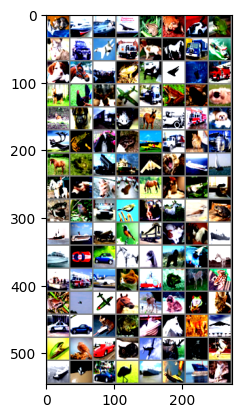

GroundTruth:  cat   ship  ship  plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [8]:
# net= ResNet_MOE_Model(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef).to(device)
# net= ResNet_multiMOE_Model(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef).to(device)
net= ResNet20().to(device)
Path= f"saved_cnn/_cifar10_resnet_moe.pt"
net.load_state_dict(torch.load(Path, weights_only=True))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        # outputs,_ = net(images)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 82 %


In [9]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # outputs,_ = net(images)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 81.2 %
Accuracy for class: car   is 89.8 %
Accuracy for class: bird  is 73.5 %
Accuracy for class: cat   is 63.1 %
Accuracy for class: deer  is 81.8 %
Accuracy for class: dog   is 76.5 %
Accuracy for class: frog  is 85.3 %
Accuracy for class: horse is 87.2 %
Accuracy for class: ship  is 89.8 %
Accuracy for class: truck is 95.2 %
